Uso del modello SVM semplice per la ricerca degli iperparametri migliori con metodo GridSearchCV.

Loading data...
Data loaded! X shape: (112800, 784), y shape: (112800,)
Using small sample for debugging: X shape: (11280, 784)
Train shape: (9024, 784), Test shape: (2256, 784)
Starting grid search...
Best parameters found: {'C': 10, 'gamma': 0.01}
Best cross-validation accuracy: 0.7488918439716312
Classification report for best model:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51        48
           1       0.54      0.59      0.56        56
          10       0.72      0.86      0.78        50
          11       0.65      0.82      0.73        44
          12       0.80      0.87      0.83        52
          13       0.75      0.66      0.70        50
          14       0.85      0.85      0.85        48
          15       0.72      0.69      0.71        52
          16       0.77      0.85      0.81        48
          17       0.93      0.84      0.89        51
          18       0.67      0.71      0.69        58
          19

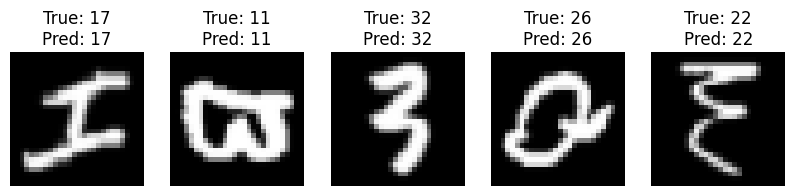

Best model saved as best_svm_model.pkl


In [6]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib

np.random.seed(42)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('L')  # Converti in scala di grigi
                img_array = np.array(img)
                if img_array.shape != (28, 28):
                    img = img.resize((28, 28))
                    img_array = np.array(img)
                images.append(img_array.flatten())  # Appiattisci l'immagine in un array
                labels.append(label)
            except (UnidentifiedImageError, OSError) as e:
                print(f"Error opening image {img_path}: {e}")
                continue
    
    return images, labels

def load_images_and_labels(base_dir):
    """Carica tutte le immagini e le etichette dalle sottocartelle di base_dir."""
    X = []  # Lista per le immagini
    y = []  # Lista per le etichette
    
    class_names = sorted(os.listdir(base_dir))  # Nome delle sottocartelle
    
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            images, labels = load_images_from_folder(class_dir, class_name)
            X.extend(images)
            y.extend(labels)
    
    X = np.array(X)
    y = np.array(y)

    X = X / 255.0  # Normalizza le immagini
    
    return X, y

def stratified_sample(X, y, test_size=0.9, random_state=42):
    """Esegue un campionamento stratificato mantenendo la proporzione delle classi."""
    X_sampled = []
    y_sampled = []
    
    class_labels = np.unique(y)
    
    for label in class_labels:
        X_class = X[y == label]
        y_class = y[y == label]
        
        X_train_class, _, y_train_class, _ = train_test_split(X_class, y_class, 
                                                              test_size=test_size, 
                                                              random_state=random_state)
        
        X_sampled.extend(X_train_class)
        y_sampled.extend(y_train_class)
    
    return np.array(X_sampled), np.array(y_sampled)

def display_sample_results(X_test, y_test, y_pred, n_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 5))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        ax.axis('off')
    plt.show()

def main():
    train_folder = 'emnist_train'
    test_folder = 'emnist_test'
    
    print("Loading data...")
    X, y = load_images_and_labels(train_folder)
    print(f"Data loaded! X shape: {X.shape}, y shape: {y.shape}")

    # Per debug iniziale, usa solo una piccola parte dei dati
    use_small_sample = True
    if use_small_sample:
        X, y = stratified_sample(X, y, test_size=0.9, random_state=42)
        print(f"Using small sample for debugging: X shape: {X.shape}")

    # Separazione dei dati in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # Definizione della griglia di parametri per la ricerca
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
    }

    model = svm.SVC(kernel='rbf')

    # Esegui una grid search con cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=3)

    print("Starting grid search...")
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")

    # Addestramento finale con i migliori parametri
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predizione e valutazione sul set di test
    y_pred = best_model.predict(X_test)
    print("Classification report for best model:")
    print(classification_report(y_test, y_pred))

    display_sample_results(X_test, y_test, y_pred)
    
    # Salvataggio del modello addestrato
    joblib.dump(best_model, 'best_svm_model.pkl')
    print("Best model saved as best_svm_model.pkl")

if __name__ == "__main__":
    main()


Addestramento del nuovo modello OneVsRestClassifier con l'uso degli iperparametri ottimi trovati nel modulo precedente.

Loading data...
Data loaded! X shape: (112800, 784), y shape: (112800,)
Classification report for rbf kernel:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       400
           1       0.55      0.70      0.62       400
           2       0.89      0.86      0.87       400
           3       0.95      0.96      0.96       400
           4       0.91      0.91      0.91       400
           5       0.92      0.84      0.88       400
           6       0.90      0.93      0.91       400
           7       0.96      0.97      0.96       400
           8       0.89      0.91      0.90       400
           9       0.68      0.84      0.75       400
          10       0.94      0.94      0.94       400
          11       0.93      0.92      0.92       400
          12       0.93      0.94      0.94       400
          13       0.88      0.87      0.88       400
          14       0.97      0.96      0.96       400
          15       0.68  

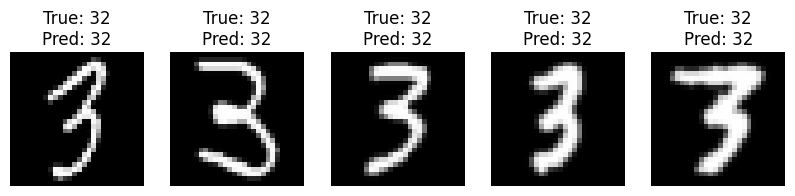

Model saved as svm_model.pkl


In [8]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib

np.random.seed(42)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('L')  # Converti in scala di grigi
                img_array = np.array(img)
                if img_array.shape != (28, 28):
                    img = img.resize((28, 28))
                    img_array = np.array(img)
                images.append(img_array.flatten())  # Appiattisci l'immagine in un array
                labels.append(label)
            except (UnidentifiedImageError, OSError) as e:
                print(f"Error opening image {img_path}: {e}")
                continue
    
    return images, labels

def load_images_and_labels(base_dir):
    """Carica tutte le immagini e le etichette dalle sottocartelle di base_dir."""
    X = []  # Lista per le immagini
    y = []  # Lista per le etichette
    
    class_names = sorted(os.listdir(base_dir))  # Nome delle sottocartelle
    
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            images, labels = load_images_from_folder(class_dir, class_name)
            X.extend(images)
            y.extend(labels)
    
    X = np.array(X)
    y = np.array(y)

    X = X / 255.0  # Normalizza le immagini
    
    return X, y


def display_sample_results(X_test, y_test, y_pred, n_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 5))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        ax.axis('off')
    plt.show()

def main():
    train_folder = 'emnist_train'
    test_folder = 'emnist_test'
    
    print("Loading data...")
    X, y = load_images_and_labels(train_folder)
    print(f"Data loaded! X shape: {X.shape}, y shape: {y.shape}")

    X_train, y_train = load_images_and_labels(train_folder)
    X_test, y_test = load_images_and_labels(test_folder)

    model = OneVsRestClassifier(svm.SVC(kernel='rbf', C=10, gamma=0.01), n_jobs=-1)
    model.fit(X_train, y_train)
        
    # Valutazione del modello
    y_pred = model.predict(X_test)
    print(f"Classification report for rbf kernel:")
    print(classification_report(y_test, y_pred))
    
    # Visualizza alcuni risultati
    display_sample_results(X_test, y_test, y_pred)

    
    # Salvataggio del modello addestrato
    joblib.dump(model, 'svm_model.pkl')
    print("Model saved as svm_model.pkl")

if __name__ == "__main__":
    main()
